# Random Coefficients Logit Tutorial - PyBLP


This tutorial follows Section 4 of the paper from Aviv Nevo (2000): "A practitioner’s guide to estimation of random‐coefficients logit models of demand.  *Journal of Economics & Management Strategy*, 9 (4), 513-548".

The paper shows a possible application of the random-coefficients Logit model. We are going to use the same data and solve the paper’s cereal problem. The data is fake, and should only be used to learn the method.

We will use the PyBLP package for Python 3. Documentation for this package can be found at https://pyblp.readthedocs.io/en/stable/index.html .

### Theory of Random Coefficients Logit
This method retains the benefits of simpler discrete-choice models: it can be estimated using only market-level price and quantity data and it deals with the endogeneity of prices. Moreover, it returns more realistic demand elasticities than Logit/Nested Logit models. 

The chosen specification of the indirect utility of consumer $i$ from consuming product $j$ in market $t$ is:

$u_{ijt} = \alpha_i p_{jt} + x'_{jt} \beta_i + \xi_{jt} + \epsilon_{ijt}$

Where $p_{jt}$ is the price, $x'_{jt}$ is the (row) vector of $K$ observable characteristics of the product, $\epsilon_{ijt}$ is the mean-zero stochastic term,  i.i.d. distributed with the Type I Extreme Value (Gumbel) distribution, and $\xi_{jt}$ is the unobserved (by the econometrician) characteristics.

This specification can be derived from a quasilinear utility function (free of wealth effects) because of the way price enters the indirect utility function. Including wealth effects could be more reasonable for other types of products (e.g. cars). Notice that $\xi_{jt}$, which among other things captures the elements of vertical product differentiation, is identical for all consumers, while $\alpha_i$ varies: this is consistent with the theoretical literature of vertical product differentiation.

The mean utility of the outside good is normalized to zero, so that $u_{i0t} = \epsilon_{i0t}$.

We can separate the linear component of utility from the non-linear one: $u_{ijt} = \delta_{jt} + \mu_{ijt} \;$, where $\delta_{jt} = \alpha p_{jt} + x'_{jt} \bar\beta + \xi_{jt} \;$ is the aspects of mean utility that all individuals agree on, and $\mu_{ijt}(\theta) \;$ is the individual specific heterogeneity (let $\theta$ be a vector with all parameters of the model).

Consumers are assumed to purchase one unit of the good that gives the highest utility. The set of individual attributes that lead to the choice of good $j$ is:

$A_{jt}(\delta) = \{\mu_i \; | \; \delta_{jt} + \mu_{ijt} > \delta_{j't} + \mu_{ij't},\; \text{for all} \; j' \neq j \}$

Therefore, the estimated market share of product $j$ is:

$S_{jt}(\delta_{jt}, \theta) = \int_{A_{jt}} \frac{\exp{(\delta_{jt} + \mu_{ijt})}}{1+\sum_k \exp{(\delta_{kt} + \mu_{ikt})}}d\mu $

For each $\theta$ there is a unique $\delta_{jt}(\theta)$ that solves $S^{obs}_{jt} - S_{jt}(\delta_{jt}, \theta) = 0 \;$ (Berry, 1994). This system of equations is nonlinear and is solved numerically. It can be solved by using the contraction mapping suggested by BLP(1995), which means computing the series:

$\delta_{jt}^{h+1} = \delta_{jt}^{h} + ln(S^{obs}_{jt}) - ln(S_{jt}(\delta_{jt}^{h}, \theta))\;\;\;\;$ (see BLP Appendix I for proof of convergence)

where $h=0, \ldots, H$, $H$ is the smallest integer such that $||\delta_{jt}^{H}-\delta_{jt}^{H-1}||$ is smaller than some tolerance level, and $\delta_{jt}^{H}$ is the approximation to $\delta_{jt}$. In words, we begin evaluating the right-hand side of the series at some initial guess for $\theta$ and $\delta_{jt}$, obtain a new $\delta_{jt}^{h}$, substitute $\delta_{jt}^{h}$ back into the right-hand side of the series, and repeat the process until convergence. 

We then compute the error term vector $\hat\xi_{jt}(\theta)$. Let $z_{jt}$ be a set of instruments such that $E[z'_{jt} \xi_{jt}(\theta)] = 0$. The GMM estimate is then

$\hat\theta_{GMM} = \underset{\theta}{\operatorname{argmin}} \; \xi(\theta)' z_{jt} \Phi^{-1} z'_{jt} \xi(\theta)$

where $\Phi$ is the variance-covariance matrix of the moments. The inverse is used to give less weight to those moments that have higher variance.

### Specification of Random Taste Parameters

We have to specify an initial guess of the nonlinear parameters. This serves two primary purposes: speeding up estimation and indicating to the solver through initial values of zero which parameters are restricted to be always zero.
It is common to assume that the random taste parameters follow a multivariate normal distribution, and to break them up into three parts:

$\begin{pmatrix} \alpha_i \\ \beta_i \end{pmatrix} =\begin{pmatrix} \alpha \\ \beta \end{pmatrix} + \Pi d_i + \Sigma v_i$.

where $\alpha$ and $\beta$ are the mean taste which all individuals agree on, $d_i$ is a $D\times1$ vector of known demographic variables, $\Pi$ is a $(K+1)\times D$ matrix of coefficients that measure how the taste characteristics vary with demographics, $\Sigma$ is a $(K+1)\times (K+1)$ matrix of parameters, and $v_i$ represents unknown individual characteristics. We cannot directly observe individual data about $d_i$ and $v_i$. The difference between the two is that we know something about the distribution of demographics $d_i$ (e.g. thorugh census data).

### The Data
The data used for the analysis below consists of `shares` and `prices` for 24 brands of breakfast cereals (a differentiated product ) in 47 cities over 2 quarters (`quarter`). `market_ids` are the unique market identifiers (which we subscript $t$). Whithin a market, the sum of all `shares` must be less than 1. Firm and brand are identified by columns `firm_ids`, `product_ids`. There are two product characteristics: `Sugar`, which measures sugar content, and `Mushy`, a dummy variable equal to one if the product gets soggy in milk. There are 20 pre-computed instruments (`demand_instruments0`, ... , `demand_instruments19`). These represent only the excluded instruments. The exogenous regressors will be automatically added to the set of instruments. Finally, demographic variables include the log of income (`Income`), the log of income squared, (`Income Sq`), `Age`, and `Child`, a dummy variable equal to one if the individual is less than sixteen.




## Code

We start with a plain logit model and then progressively move towards random effects.

Before jumping into the code, let's go over some reserved variable names:

1. `market_ids`: unique market identifiers
2. `shares`: specifies market shares within `market_ids`
3. `prices`: endogenous prices
4. `demand_instruments_0`, `demand_instruments_1`: excluded instruments

In [1]:
# Set up
import pyblp
import numpy as np
import pandas as pd

pyblp.options.digits = 2
pyblp.options.verbose = False
pyblp.__version__

'0.12.0'

In [3]:
# Import data
product_data = pd.read_csv(pyblp.data.NEVO_PRODUCTS_LOCATION)
product_data.head()

# Note that the data already includes instruments. The library support calculation of demand instruments.
# Check out: https://pyblp.readthedocs.io/en/stable/api.html#data-construction-functions

,market_ids,city_ids,quarter,product_ids,firm_ids,brand_ids,shares,prices,sugar,mushy,...,demand_instruments10,demand_instruments11,demand_instruments12,demand_instruments13,demand_instruments14,demand_instruments15,demand_instruments16,demand_instruments17,demand_instruments18,demand_instruments19
0,C01Q1,1,1,F1B04,1,4,0.012417,0.072088,2,1,...,2.116358,-0.154708,-0.005796,0.014538,0.126244,0.067345,0.068423,0.034800,0.126346,0.035484
1,C01Q1,1,1,F1B06,1,6,0.007809,0.114178,18,1,...,-7.374091,-0.576412,0.012991,0.076143,0.029736,0.087867,0.110501,0.087784,0.049872,0.072579
2,C01Q1,1,1,F1B07,1,7,0.012995,0.132391,4,1,...,2.187872,-0.207346,0.003509,0.091781,0.163773,0.111881,0.108226,0.086439,0.122347,0.101842
3,C01Q1,1,1,F1B09,1,9,0.005770,0.130344,3,0,...,2.704576,0.040748,-0.003724,0.094732,0.135274,0.088090,0.101767,0.101777,0.110741,0.104332
4,C01Q1,1,1,F1B11,1,11,0.017934,0.154823,12,0,...,1.261242,0.034836,-0.000568,0.102451,0.130640,0.084818,0.101075,0.125169,0.133464,0.121111


In [4]:
# Let's check out our data
products = product_data['product_ids'].value_counts()
markets = product_data['market_ids'].value_counts()

print(products)

F1B17    94
F3B14    94
F2B19    94
F6B18    94
F1B13    94
F2B28    94
F1B11    94
F2B40    94
F2B26    94
F2B08    94
F1B04    94
F4B12    94
F2B48    94
F2B15    94
F1B30    94
F3B06    94
F2B16    94
F1B09    94
F1B45    94
F1B07    94
F2B05    94
F1B06    94
F4B02    94
F4B10    94
Name: product_ids, dtype: int64


In [10]:
# Number of products and markets
num_products = products.shape[0]
num_markets = markets.shape[0]

print(f'We have {num_products} products in our data set.')
print(f'We have {num_markets} markets in our data set.')

We have 24 products in our data set.
We have 94 markets in our data set.


In [11]:
# Some descriptives
product_data.describe()

,city_ids,quarter,firm_ids,brand_ids,shares,prices,sugar,mushy,demand_instruments0,demand_instruments1,...,demand_instruments10,demand_instruments11,demand_instruments12,demand_instruments13,demand_instruments14,demand_instruments15,demand_instruments16,demand_instruments17,demand_instruments18,demand_instruments19
count,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,...,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000,2256.000000
mean,32.340426,1.500000,2.125000,17.041667,0.019825,0.125740,8.625000,0.333333,0.025432,-0.002419,...,-0.515369,-0.144608,0.003708,0.090780,0.091614,0.090725,0.091702,0.090843,0.091712,0.090812
std,17.674998,0.500111,1.268893,12.610594,0.025600,0.029035,5.787851,0.471509,0.375534,0.045155,...,3.990604,0.236072,0.016006,0.030867,0.058537,0.051407,0.042725,0.030745,0.054232,0.029365
min,1.000000,1.000000,1.000000,2.000000,0.000182,0.045487,0.000000,0.000000,-1.069056,-0.195411,...,-17.193444,-0.915056,-0.086395,0.003210,-0.164910,-0.070215,-0.049078,-0.003689,-0.083744,-0.002656
25%,16.000000,1.000000,1.000000,7.750000,0.005183,0.105491,3.000000,0.000000,-0.212389,-0.023902,...,-2.865767,-0.301611,-0.005808,0.070321,0.051978,0.056119,0.061993,0.070375,0.054265,0.070948
50%,33.000000,1.500000,2.000000,13.500000,0.011141,0.123829,8.500000,0.000000,0.030063,0.001283,...,-0.271513,-0.038457,0.004256,0.088880,0.092130,0.090167,0.092052,0.088712,0.091365,0.089010
75%,47.000000,2.000000,2.250000,20.750000,0.024646,0.143293,13.250000,1.000000,0.232839,0.026311,...,2.086112,0.013594,0.015140,0.109991,0.130278,0.125697,0.121167,0.109972,0.128666,0.109260
max,65.000000,2.000000,6.000000,48.000000,0.446883,0.225728,20.000000,1.000000,1.090208,0.122818,...,10.193893,0.423279,0.049963,0.206038,0.283321,0.271270,0.253372,0.206615,0.291082,0.188043


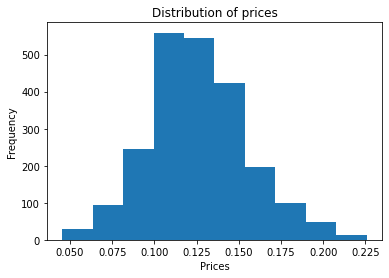

In [12]:
# Let's plot something
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(product_data['prices'])
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.title('Distribution of prices')
plt.show()

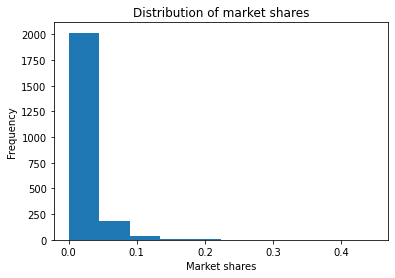

In [13]:
plt.hist(product_data['shares'])
plt.xlabel('Market shares')
plt.ylabel('Frequency')
plt.title('Distribution of market shares')
plt.show()

In [17]:
# Set up: Need to specify the formulation of our demand model
logit_formulation = pyblp.Formulation('prices', absorb='C(product_ids)')
print(logit_formulation)

prices + Absorb[C(product_ids)]


In [18]:
# With the formulation, we can set up the problem
problem = pyblp.Problem(logit_formulation, product_data)
problem

Dimensions:
 T    N     F    K1    MD    ED 
---  ----  ---  ----  ----  ----
94   2256   5    1     20    1  

Formulations:
     Column Indices:          0   
--------------------------  ------
X1: Linear Characteristics  prices

In the output above, we have the following information:

$T$: number of markets

$N$: number of product-market observations

$F$: number of firms (not used in this example)

$K_1$: dimension of linear demand parameters

$M_D$: dimension of the instrument variables (excluded instruments + exogenous variables)

$E_D$: number of fixed effect dimensions (e.g. one-dimensional fixed effects)

In [19]:
# Let's compute it
logit_results = problem.solve()
logit_results

Problem Results Summary:
GMM   Objective  Clipped  Weighting Matrix
Step    Value    Shares   Condition Number
----  ---------  -------  ----------------
 2    +1.9E+02      0         +5.7E+07    

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         2     

Beta Estimates (Robust SEs in Parentheses):
  prices  
----------
 -3.0E+01 
(+1.0E+00)

In [21]:
# We can check out the estimated parameter(s)
logit_results.parameters

# For all the results methods, check out: https://pyblp.readthedocs.io/en/stable/api.html#problem-results-class

array([[-30.04710289]])

In [28]:
# We can check out a whole variety of estimation results
# Check here for more info: https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.to_dict.html#pyblp.ProblemResults.to_dict
logit_results_dict = logit_results.to_dict()
#logit_results_dict

array([[-30.04710289]])

## Random coefficients

If we want to include demographic information to estimate how tastes correlate for different product characteristics we can estimate a random coefficients model. Like mentioned in the introduction, this means that we now must include non-linear demand-side parameters collected in $\mu_{ijt}$.

Just like in the logit model, our data consists of the following information:

$T$: number of markets

$N$: number of product-market observations

$F$: number of firms (not used in this example)

$K_1$: dimension of linear demand parameters

$K_2$: dimension of non-linear parameters

$M_D$: dimension of the instrument variables (excluded instruments + exogenous variables)

$E_D$: number of fixed effect dimensions (e.g. one-dimensional fixed effects)

In [29]:
# Import data
product_data = pd.read_csv(pyblp.data.NEVO_PRODUCTS_LOCATION)
product_data.head()

,market_ids,city_ids,quarter,product_ids,firm_ids,brand_ids,shares,prices,sugar,mushy,...,demand_instruments10,demand_instruments11,demand_instruments12,demand_instruments13,demand_instruments14,demand_instruments15,demand_instruments16,demand_instruments17,demand_instruments18,demand_instruments19
0,C01Q1,1,1,F1B04,1,4,0.012417,0.072088,2,1,...,2.116358,-0.154708,-0.005796,0.014538,0.126244,0.067345,0.068423,0.034800,0.126346,0.035484
1,C01Q1,1,1,F1B06,1,6,0.007809,0.114178,18,1,...,-7.374091,-0.576412,0.012991,0.076143,0.029736,0.087867,0.110501,0.087784,0.049872,0.072579
2,C01Q1,1,1,F1B07,1,7,0.012995,0.132391,4,1,...,2.187872,-0.207346,0.003509,0.091781,0.163773,0.111881,0.108226,0.086439,0.122347,0.101842
3,C01Q1,1,1,F1B09,1,9,0.005770,0.130344,3,0,...,2.704576,0.040748,-0.003724,0.094732,0.135274,0.088090,0.101767,0.101777,0.110741,0.104332
4,C01Q1,1,1,F1B11,1,11,0.017934,0.154823,12,0,...,1.261242,0.034836,-0.000568,0.102451,0.130640,0.084818,0.101075,0.125169,0.133464,0.121111


For the estmation, we proceed with the following steps:

1. Define a formulation for the (linear) $X_1$ demand model.
2. Define a formulation for the (nonlinear) $X_2$ demand model. This should only include the variables over which we want random effects. 
3. Define an `Integration` configuration.
4. Combine the `Formlation` classes, `product_data` and the `Integration` configuration to construct a `Problem`. 

In [40]:
X1_formulation = pyblp.Formulation('0 + prices', absorb='C(product_ids)')
X2_formulation = pyblp.Formulation('1 + prices + sugar + mushy')
product_formulations = (X1_formulation, X2_formulation)
product_formulations

(prices + Absorb[C(product_ids)], 1 + prices + sugar + mushy)

In [41]:
# Define integration configuration (MC draws from standard normal for 50 individuals)
mc_integration = pyblp.Integration('monte_carlo', size=50, specification_options={'seed': 0})
mc_integration

Configured to construct nodes and weights with Monte Carlo simulation with options {seed: 0}.

In [42]:
# Set up the problem we are trying to solve
mc_problem = pyblp.Problem(product_formulations, product_data, integration=mc_integration)
mc_problem

Dimensions:
 T    N     F    I     K1    K2    MD    ED 
---  ----  ---  ----  ----  ----  ----  ----
94   2256   5   4700   1     4     20    1  

Formulations:
       Column Indices:           0       1       2      3  
-----------------------------  ------  ------  -----  -----
 X1: Linear Characteristics    prices                      
X2: Nonlinear Characteristics    1     prices  sugar  mushy

In [48]:
# Set up optimization configuration
bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-4})

results1 = mc_problem.solve(sigma=np.eye(4), optimization=bfgs)
results1

Problem Results Summary:
GMM   Objective  Gradient      Hessian         Hessian     Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Min Eigenvalue  Max Eigenvalue  Shares   Condition Number  Condition Number 
----  ---------  --------  --------------  --------------  -------  ----------------  -----------------
 2    +1.8E+02   +1.3E-06     +1.1E+00        +6.0E+03        0         +5.8E+07          +4.8E+04     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:00:35       Yes          16           24          18586        57463   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:      1         prices      sugar       mushy   
------  ----------  ----------  ----------  ----------
  1      +5.2E-02                                     
    

In [50]:
# We can access the estimated parameters of our model
results1.parameters

array([[  0.05247994],
       [ -0.43386799],
       [  0.03563226],
       [  0.50109754],
       [-30.21223885]])

In [51]:
# Again, we can create a dict with all results
results1_dict = results1.to_dict()
#results1_dict

## Estimation of marginal costs

From the results class we can estimate marginal costs for each firm based multi-product differentiated first-order conditions. Then, marginal costs are estimated following

$$ p - c = \eta $$

The mark-up $ \eta = \Delta^{-1}s $ depends on $ \Delta $, a $J_t \times J_t$ matrix of intra-firm (negative) demand derivatives.

For more information, see: https://pyblp.readthedocs.io/en/stable/_api/pyblp.ProblemResults.compute_costs.html

In [52]:
# Compute marginal costs
marginal_costs = results1.compute_costs()
marginal_costs

array([[0.03425579],
       [0.07609447],
       [0.09452116],
       ...,
       [0.10316988],
       [0.06627124],
       [0.0935867 ]])

In [54]:
# Computes marginal costs for each product x market
marginal_costs.shape

(2256, 1)

## Adding demograhpic information

In [56]:
# Import demograhpic information
agent_data = pd.read_csv(pyblp.data.NEVO_AGENTS_LOCATION)
agent_data.head()

,market_ids,city_ids,quarter,weights,nodes0,nodes1,nodes2,nodes3,income,income_squared,age,child
0,C01Q1,1,1,0.05,0.434101,-1.500838,-1.151079,0.161017,0.495123,8.331304,-0.230109,-0.230851
1,C01Q1,1,1,0.05,-0.726649,0.133182,-0.500750,0.129732,0.378762,6.121865,-2.532694,0.769149
2,C01Q1,1,1,0.05,-0.623061,-0.138241,0.797441,-0.795549,0.105015,1.030803,-0.006965,-0.230851
3,C01Q1,1,1,0.05,-0.041317,1.257136,-0.683054,0.259044,-1.485481,-25.583605,-0.827946,0.769149
4,C01Q1,1,1,0.05,-0.466691,0.226968,1.044424,0.092019,-0.316597,-6.517009,-0.230109,-0.230851


In [58]:
agent_formulation = pyblp.Formulation('0 + income + income_squared + age + child')
agent_formulation

income + income_squared + age + child

In [59]:
nevo_problem = pyblp.Problem(
    product_formulations,
    product_data,
    agent_formulation,
    agent_data
)
nevo_problem

Dimensions:
 T    N     F    I     K1    K2    D    MD    ED 
---  ----  ---  ----  ----  ----  ---  ----  ----
94   2256   5   1880   1     4     4    20    1  

Formulations:
       Column Indices:           0           1           2      3  
-----------------------------  ------  --------------  -----  -----
 X1: Linear Characteristics    prices                              
X2: Nonlinear Characteristics    1         prices      sugar  mushy
       d: Demographics         income  income_squared   age   child

In [60]:
# Initialize initial value for numerical optimization (same as in Nevo (2000))
initial_sigma = np.diag([0.3302, 2.4526, 0.0163, 0.2441])
#initial_sigma = np.diag([1, 1, 1, 1])


initial_pi = np.array([
  [ 5.4819,  0,      0.2037,  0     ],
  [15.8935, -1.2000, 0,       2.6342],
  [-0.2506,  0,      0.0511,  0     ],
  [ 1.2650,  0,     -0.8091,  0     ]
])

In [61]:
# Set up optimization configuration
tighter_bfgs = pyblp.Optimization('bfgs',
                                  {'gtol': 1e-5}
                                 )

# Solve problem
nevo_results = nevo_problem.solve(
    initial_sigma,
    initial_pi,
    optimization=tighter_bfgs,
    method='1s'
)
nevo_results

Problem Results Summary:
GMM   Objective  Gradient      Hessian         Hessian     Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Min Eigenvalue  Max Eigenvalue  Shares   Condition Number  Condition Number 
----  ---------  --------  --------------  --------------  -------  ----------------  -----------------
 1    +4.6E+00   +6.9E-06     +3.1E-05        +1.6E+04        0         +6.9E+07          +8.4E+08     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:01:28       Yes          51           57          45474       141154   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:      1         prices      sugar       mushy     |   Pi:      income    income_squared     age        child   
------  ----------  ----------  ----------  -------

## Computation of elasticities

For more detailed info: https://pyblp.readthedocs.io/en/stable/_notebooks/tutorial/post_estimation.html

Recall that elasticities in each market are given by

$$ \epsilon_{jk} = \frac{x_{kt}}{s_{jt}}\frac{\partial s_{jt}}{\partial x_{kt}} $$

where $x_k$ is the $k$th product attribute (by default this is equal to $p$)

In [63]:
elasticities = nevo_results.compute_elasticities()
elasticities.shape

(2256, 24)

In [66]:
# Note that if we call the compute_elasticities method, elasticities for all markets are computed and stacked.
# Might be more illuminating to check out the elasticity matrix for a single market.

# Compute for single market; note that for some reasons the kwarg market_id must not be str
elasticities_single = nevo_results.compute_elasticities(name='prices', market_id=['C65Q2'])
print(elasticities_single.shape)

(24, 24)


In [67]:
nevo_results.pi

array([[ 2.29197146e+00,  0.00000000e+00,  1.28443201e+00,
         0.00000000e+00],
       [ 5.88325089e+02, -3.01920128e+01,  0.00000000e+00,
         1.10546281e+01],
       [-3.84954073e-01,  0.00000000e+00,  5.22342705e-02,
         0.00000000e+00],
       [ 7.48372300e-01,  0.00000000e+00, -1.35339323e+00,
         0.00000000e+00]])

In [1]:
# Some things that still need doing:

# Discuss interpretation
# Add some plots of parameter distributions
# Matrix for elasticities